## First trial
For the first trial, a reduced part of the dataset will be used (5%)

In [1]:
## import libs
import pandas as pd
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import joblib
import matplotlib.pyplot as plt

c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
## get a reduced slice of the dataset
dataset = pd.read_csv("./datasets/train_processed.csv")
dataset = dataset.sample(frac=0.05, random_state=42)
dataset.to_csv("./datasets/train_reduced.csv", index=False)
dataset["satisfaction"]

dataset_test = pd.read_csv("./datasets/test_processed.csv")
dataset_test = dataset_test.sample(frac=0.05, random_state=42)

dataset_validation = pd.read_csv("./datasets/validation_processed.csv")
dataset_validation = dataset_validation.sample(frac=0.05, random_state=42)


In [32]:
### define the features ###
y_train = dataset["satisfaction"]
X_train = dataset.drop(columns=["satisfaction"])

y_test = dataset_test["satisfaction"]
X_test = dataset_test.drop(columns=["satisfaction"])

y_validation = dataset_validation["satisfaction"]
X_validation = dataset_validation.drop(columns=["satisfaction"])

y_train

55048    2
62524    2
484      1
31026    1
34627    1
        ..
67653    1
65466    1
59585    1
46538    2
20549    2
Name: satisfaction, Length: 3398, dtype: int64

### Hyperparamenters
To optimize the choice process of the hyperparameters, optuna library will be used to create a study case and select the best option to model our MLP with the best values

In [16]:
### use optuna to best tune the hyperparameters ###
def obj_func(trial):
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [1, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"])
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    alpha = trial.suggest_float("alpha", 0.0001, 0.1)
    max_iter = trial.suggest_int("max_iter", 200, 1000)
    tol = trial.suggest_float("tol", 1e-5, 1e-3)

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes, 
        activation=activation, 
        solver=solver, 
        learning_rate=learning_rate, 
        alpha=alpha, 
        max_iter=max_iter, 
        tol=tol
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(obj_func, n_trials=100)

trial = study.best_trial
print("Best trial:")
print("Value: ", trial.value)
print("Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-06-30 15:34:15,049] A new study created in memory with name: no-name-2a08adff-004d-4c16-9b9c-e78b436f20f1
[I 2024-06-30 15:34:17,710] Trial 0 finished with value: 0.8683602771362586 and parameters: {'hidden_layer_sizes': 20, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'adaptive', 'alpha': 0.07703376011478683, 'max_iter': 937, 'tol': 0.0005109601527172201}. Best is trial 0 with value: 0.8683602771362586.
[I 2024-06-30 15:34:36,247] Trial 1 finished with value: 0.8953040800615858 and parameters: {'hidden_layer_sizes': 100, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'adaptive', 'alpha': 0.093128146912676, 'max_iter': 456, 'tol': 0.00012853770882294686}. Best is trial 1 with value: 0.8953040800615858.
[I 2024-06-30 15:34:36,896] Trial 2 finished with value: 0.8737490377213241 and parameters: {'hidden_layer_sizes': 10, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'constant', 'alpha': 0.09977570485505072, 'max_iter': 220, 'tol': 0.0009595

Best trial:
Value:  0.9268668206312548
Params: 
    hidden_layer_sizes: 90
    activation: tanh
    solver: adam
    learning_rate: constant
    alpha: 0.038443740103269626
    max_iter: 505
    tol: 7.133281723715193e-05


As seen above, the values of the hyperparameters that maximize the accuracy score (92.68%) of the predicted model is:
- hidden layers: 90
- activation: tanh
- solver: adam
- lr: constant
- alpha: 0.03
- max iteractions: 505
- tol: 7.13e-05

### trainning the model
Now it's time to train the reduced model with the defined hyperparameters

In [4]:
### hyperparameters ###
hidden_layer_sizes = (90,)
activation = "tanh"
solver = "adam"
learning_rate = "constant"
alpha = 0.038443740103269626
max_iter = 505
tol = 7.133281723715193e-05

In [5]:
### model ###
from sklearn.metrics import log_loss


model = MLPClassifier(
    hidden_layer_sizes=(10,), 
    activation=activation, 
    solver=solver, 
    learning_rate=learning_rate, 
    alpha=alpha, 
    max_iter=max_iter, 
    tol=tol,
)

loss = []
validation_loss = []

for i in range(100):
    model.fit(X_train, y_train)
    loss.append(model.loss_)

    y_val_preds = model.predict_proba(X_validation)
    validation_loss_epoch = log_loss(y_validation, y_val_preds)
    validation_loss.append(validation_loss_epoch)

    if i % 10 == 0:
        print(f"Epoch {i} - Loss: {model.loss_} - Validation loss: {validation_loss_epoch} - Accuracy: {model.score(X_train, y_train)}")

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred))

print("Classification report: ")
print(classification_report(y_test, y_pred))

c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 0 - Loss: 0.13849942630179599 - Validation loss: 0.23275030480571618 - Accuracy: 0.9508534432018835


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 10 - Loss: 0.14522805907505212 - Validation loss: 0.21947128894023915 - Accuracy: 0.948204826368452


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 20 - Loss: 0.1464733940458414 - Validation loss: 0.22839568368563556 - Accuracy: 0.9473219540906416


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 30 - Loss: 0.13835794264334672 - Validation loss: 0.22130892371429584 - Accuracy: 0.9523248969982343


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 40 - Loss: 0.15689684571954485 - Validation loss: 0.23725705535535555 - Accuracy: 0.9367274867569159


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 50 - Loss: 0.13713145560249015 - Validation loss: 0.2343821337827701 - Accuracy: 0.9529134785167745


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 60 - Loss: 0.1498032811547135 - Validation loss: 0.22966255286899875 - Accuracy: 0.9467333725721012


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 70 - Loss: 0.14184341673110148 - Validation loss: 0.20989669837977212 - Accuracy: 0.9523248969982343


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 80 - Loss: 0.14944161511884105 - Validation loss: 0.2314914822215015 - Accuracy: 0.9476162448499117


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 90 - Loss: 0.14202289559881895 - Validation loss: 0.21059505934737252 - Accuracy: 0.9511477339611536


c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9006928406466512
Confusion matrix: 
[[678  71]
 [ 58 492]]
Classification report: 
              precision    recall  f1-score   support

           1       0.92      0.91      0.91       749
           2       0.87      0.89      0.88       550

    accuracy                           0.90      1299
   macro avg       0.90      0.90      0.90      1299
weighted avg       0.90      0.90      0.90      1299



c:\Users\mpps\anaconda3\envs\kanprojectenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (505) reached and the optimization hasn't converged yet.
  warnings.warn(


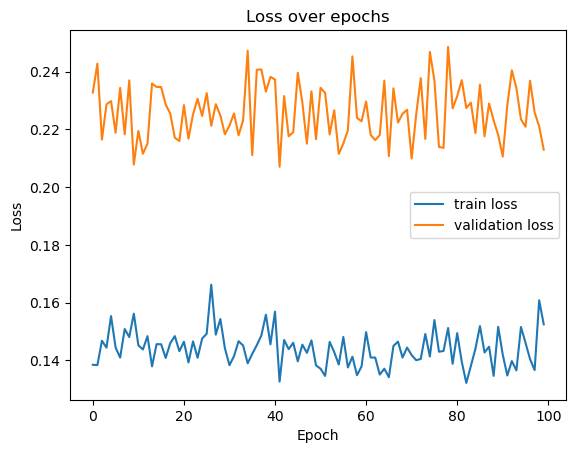

In [6]:
plt.figure()
plt.plot(range(len(loss)), loss, label="train loss")
plt.plot(range(len(loss)), validation_loss, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

As the loss is not validation loss isn't following the training loss, let us go to build another model

## Trial 2
Trying more than 1 layer

In [33]:
### import libs ###
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report
import joblib

### Object function
Below a objective funtion will be responsible for selecting the best hyperparameters

In [34]:
def objective(trial):
    hidden_layer_sizes = tuple([trial.suggest_int("n_units_l{}".format(i), 10, 100) for i in range(trial.suggest_int("n_layers", 1, 3))])
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
         activation=activation, 
         solver=solver,
        alpha=alpha, 
        learning_rate=learning_rate, 
        max_iter=1000, 
        random_state=42
    )

    mlp.fit(X_train, y_train)
    
    # predicting to validation data
    y_pred = mlp.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    
    return accuracy


# creating a study case for the hp
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# best hp results
print("Best HP: ", study.best_params)

[I 2024-07-01 20:03:14,831] A new study created in memory with name: no-name-7f905134-d418-45de-a2ad-62db595b3542
C:\Users\mpps\AppData\Local\Temp\ipykernel_3544\4232508698.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
[I 2024-07-01 20:03:18,747] Trial 0 finished with value: 0.9121231558691469 and parameters: {'n_layers': 3, 'n_units_l0': 97, 'n_units_l1': 37, 'n_units_l2': 70, 'activation': 'relu', 'solver': 'adam', 'alpha': 2.1782224135808606e-05, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 0.9121231558691469.
C:\Users\mpps\AppData\Local\Temp\ipykernel_3544\4232508698.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Best HP:  {'n_layers': 1, 'n_units_l0': 82, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0007291111177671948, 'learning_rate': 'adaptive'}


### Modeling and training
Now we'll build the model with the best hp and train our model. Also, we'll watch the loss beahavior

In [35]:
best_params = study.best_params
hidden_layer_sizes = tuple([best_params["n_units_l{}".format(i)] for i in range(best_params["n_layers"])])

mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes, 
    activation=best_params['activation'], 
    solver=best_params['solver'],
    alpha=best_params['alpha'], 
    learning_rate=best_params['learning_rate'], 
    max_iter=1000, 
    random_state=42
)

train_loss = []
validation_loss = []

mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

patience = 10
best_loss = np.inf
best_epoch = 0

for i in range(1000):
    mlp.partial_fit(X_train, y_train)
    train_loss.append(mlp.loss_)
    
    y_val_preds = mlp.predict_proba(X_validation)
    validation_loss_epoch = log_loss(y_validation, y_val_preds)
    validation_loss.append(validation_loss_epoch)

    if validation_loss_epoch < best_loss:
        best_loss = validation_loss_epoch
        best_epoch = i
    
    elif i - best_epoch > patience:
        print(f"Early stopping at epoch {i}")
        break
    
    if i % 10 == 0:
        print(f"Epoch {i} - Loss: {mlp.loss_} - Validation loss: {validation_loss_epoch} - Accuracy: {mlp.score(X_train, y_train)}")


Epoch 0 - Loss: 0.646992980918303 - Validation loss: 0.6342536430680801 - Accuracy: 0.6291936433195998
Epoch 10 - Loss: 0.3586365199983127 - Validation loss: 0.3634342897860339 - Accuracy: 0.8658034137728076
Epoch 20 - Loss: 0.29738994427376697 - Validation loss: 0.31277222698135143 - Accuracy: 0.8755150088287228
Epoch 30 - Loss: 0.2801282273189545 - Validation loss: 0.2973227783059918 - Accuracy: 0.8781636256621542
Epoch 40 - Loss: 0.2730638240713629 - Validation loss: 0.2906142987358317 - Accuracy: 0.8811065332548558
Epoch 50 - Loss: 0.2695058827357625 - Validation loss: 0.2871109327903757 - Accuracy: 0.8840494408475574
Epoch 60 - Loss: 0.26709426043486983 - Validation loss: 0.2847383262924786 - Accuracy: 0.8864037669217186
Epoch 70 - Loss: 0.26467532450139947 - Validation loss: 0.2823878347565905 - Accuracy: 0.886992348440259
Epoch 80 - Loss: 0.26163074741340453 - Validation loss: 0.2794419699150296 - Accuracy: 0.8893466745144203
Epoch 90 - Loss: 0.25785330365429415 - Validation los

In [36]:
y_pred = mlp.predict(X_test)

# evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### save the model ###
joblib.dump(mlp, "./models/mlp_trial2.pkl")

[[671  78]
 [ 41 509]]
              precision    recall  f1-score   support

           1       0.94      0.90      0.92       749
           2       0.87      0.93      0.90       550

    accuracy                           0.91      1299
   macro avg       0.90      0.91      0.91      1299
weighted avg       0.91      0.91      0.91      1299



['./models/mlp_trial2.pkl']

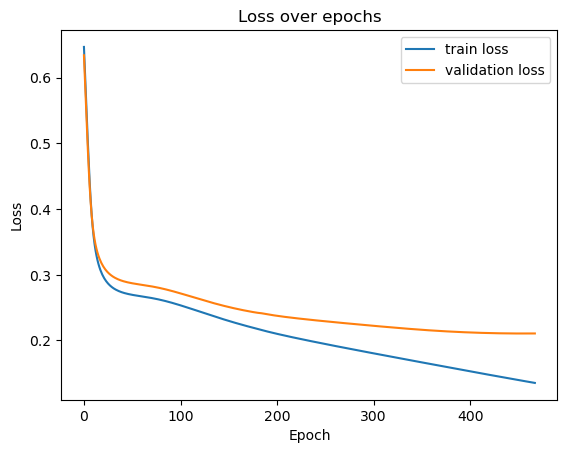

In [37]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(train_loss)), validation_loss, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

As the result above was satisfactive, let's run an oficial test!

## Oficial trial
All dataset.
Since it's size, creating checkpoints will be necessary

In [4]:
### import libs ###
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
import seaborn as sns

In [5]:
dataset_train = pd.read_csv("./datasets/train_processed.csv")
dataset_test = pd.read_csv("./datasets/test_processed.csv")
dataset_validation = pd.read_csv("./datasets/validation_processed.csv")

y_train = dataset_train["satisfaction"]
X_train = dataset_train.drop(columns=["satisfaction"])

y_test = dataset_test["satisfaction"]
X_test = dataset_test.drop(columns=["satisfaction"])

y_validation = dataset_validation["satisfaction"]
X_validation = dataset_validation.drop(columns=["satisfaction"])

y_train

0        1
1        1
2        2
3        1
4        2
        ..
67963    1
67964    2
67965    1
67966    1
67967    1
Name: satisfaction, Length: 67968, dtype: int64

In [40]:
best_params = study.best_params
hidden_layer_sizes = tuple([best_params["n_units_l{}".format(i)] for i in range(best_params["n_layers"])])

mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes, 
    activation=best_params['activation'], 
    solver=best_params['solver'],
    alpha=best_params['alpha'], 
    learning_rate=best_params['learning_rate'], 
    max_iter=1000, 
    random_state=42
)

train_loss = []
validation_loss = []
acc_over_epochs = []
mse_over_epochs = []

mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

patience = 10
best_loss = np.inf
best_epoch = 0

for i in range(1000):
    mlp.partial_fit(X_train, y_train)
    train_loss.append(mlp.loss_)
    
    y_val_preds = mlp.predict_proba(X_validation)
    validation_loss_epoch = log_loss(y_validation, y_val_preds)
    validation_loss.append(validation_loss_epoch)

    accuracy = accuracy_score(y_validation, mlp.predict(X_validation))
    acc_over_epochs.append(accuracy)

    mse = mean_squared_error(y_validation, mlp.predict(X_validation))
    mse_over_epochs.append(mse)

    if validation_loss_epoch < best_loss:
        best_loss = validation_loss_epoch
        best_epoch = i
    
    elif i - best_epoch > patience:
        print(f"Early stopping at epoch {i}")
        break
    
    if i % 10 == 0:
        print(f"Epoch {i} - Loss: {mlp.loss_} - Validation loss: {validation_loss_epoch} - Accuracy: {mlp.score(X_train, y_train)}")
    
    if i % 100 == 0:
        joblib.dump(mlp, f"./models/oficial_trial/mlp_partial_{i}.pkl")


Epoch 0 - Loss: 0.2900539628044072 - Validation loss: 0.2841259712029874 - Accuracy: 0.8796492467043314
Epoch 10 - Loss: 0.22960190940244027 - Validation loss: 0.22507814727861972 - Accuracy: 0.9042196327683616
Epoch 20 - Loss: 0.19711589802682433 - Validation loss: 0.19335640890845535 - Accuracy: 0.9184469161958568
Epoch 30 - Loss: 0.183771735788774 - Validation loss: 0.18032495748278043 - Accuracy: 0.924817561205273
Epoch 40 - Loss: 0.174179891489617 - Validation loss: 0.17098636347773902 - Accuracy: 0.9288635828625236
Epoch 50 - Loss: 0.1651389945963449 - Validation loss: 0.16237622343197294 - Accuracy: 0.9323946563088512
Epoch 60 - Loss: 0.15705672473455815 - Validation loss: 0.15476670753242494 - Accuracy: 0.9355726224105462
Epoch 70 - Loss: 0.1506451427683369 - Validation loss: 0.148937600571779 - Accuracy: 0.938426906779661
Epoch 80 - Loss: 0.1456674628728361 - Validation loss: 0.1446376733322629 - Accuracy: 0.9403101459510358
Epoch 90 - Loss: 0.1416756033161534 - Validation los

In [41]:
y_pred = mlp.predict(X_test)

# evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### save the model ###
joblib.dump(mlp, "./models/oficial_trial/mlp_oficial.pkl")

[[13965   608]
 [  776 10627]]
              precision    recall  f1-score   support

           1       0.95      0.96      0.95     14573
           2       0.95      0.93      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976



['./models/oficial_trial/mlp_oficial.pkl']

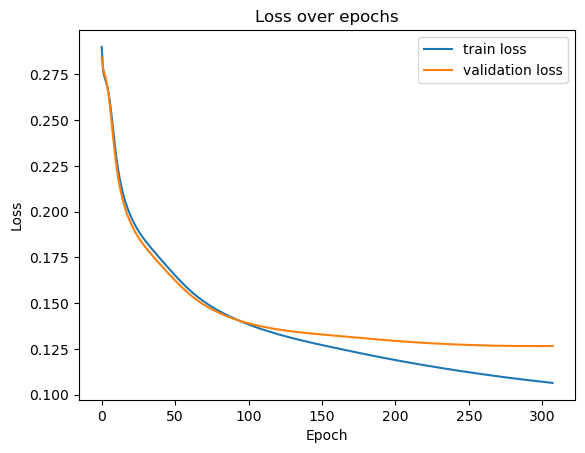

In [42]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(train_loss)), validation_loss, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()
plt.show()

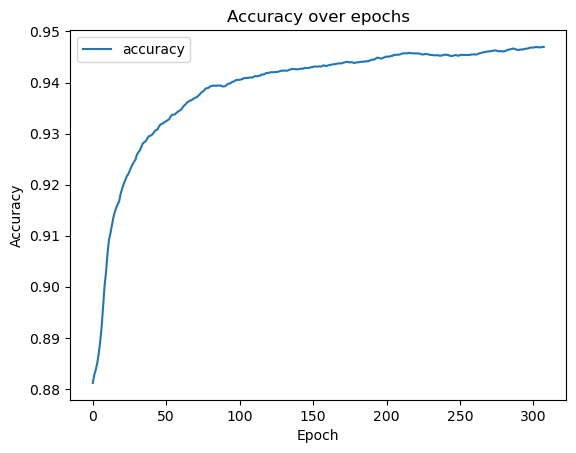

In [43]:
plt.figure()
plt.plot(range(len(acc_over_epochs)), acc_over_epochs, label="accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()
plt.show()

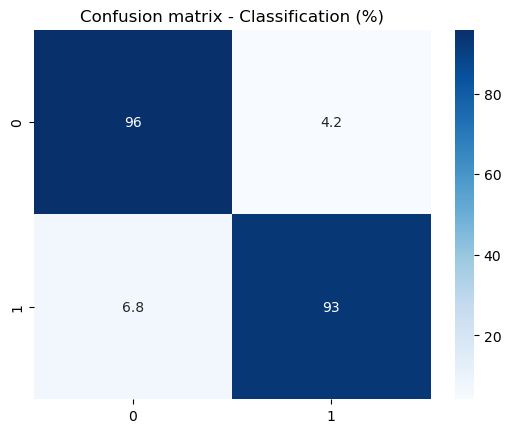

In [44]:
### plot confusion matrix ###
cf = confusion_matrix(y_test, y_pred)
cf = pd.DataFrame(cf, columns=["0", "1"], index=["0", "1"])

percentage_cf = cf.div(cf.sum(axis=1), axis=0) * 100
percentage_cf = percentage_cf.round(2)

plt.figure()
sns.heatmap(percentage_cf, annot=True, cmap="Blues")
plt.title("Confusion matrix - Classification (%)")
plt.show()

In [37]:
y_pred = mlp.predict(X_test)  # Correct method for getting class labels
y_pred

repot = classification_report(y_test, y_pred)
print(repot)

              precision    recall  f1-score   support

           1       0.95      0.96      0.95     14573
           2       0.95      0.93      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976



In [1]:
import joblib
import seaborn as sns

### load th trained model ###
mlp = joblib.load("./models/oficial_trial/mlp_oficial.pkl")

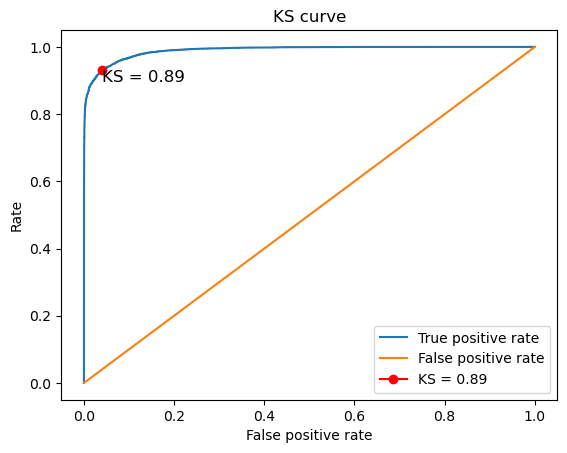

KS statistic: 0.89


In [12]:
### KS test v2 ###
from sklearn.metrics import roc_curve
import numpy as np

### predict the probabilities ###
y_pred = mlp.predict_proba(X_test)[:, 1]

### calculate the KS statistic ###
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=2)
ks_stat = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)

### plot the KS curve ###
plt.figure()
plt.plot(fpr, tpr, label="True positive rate")
plt.plot(fpr, fpr, label="False positive rate")
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], color="red", label=f"KS = {ks_stat:.2f}", marker="o")
plt.text(fpr[ks_idx], tpr[ks_idx], f"KS = {ks_stat:.2f}", fontsize=12, verticalalignment='top')
plt.xlabel("False positive rate")
plt.ylabel("Rate")
plt.title("KS curve")
plt.legend(loc="best")
plt.show()

print(f"KS statistic: {ks_stat:.2f}")


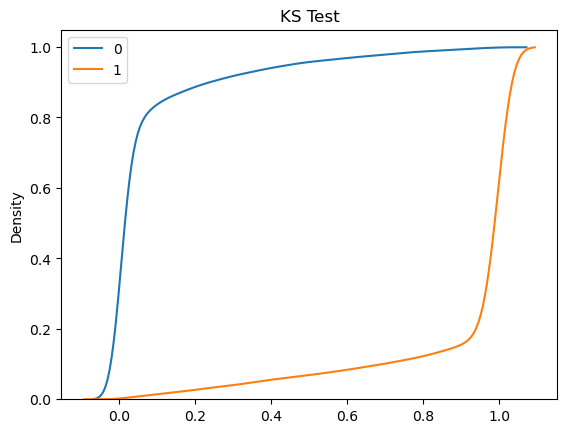

In [47]:
### KS Test ###
from scipy.stats import ks_2samp

y_pred = mlp.predict_proba(X_test)[:, 1]
y_test_0 = y_pred[y_test == 1]
y_test_1 = y_pred[y_test == 2]

ks_2samp(y_test_0, y_test_1)

# KS Test plot
plt.figure()
sns.kdeplot(y_test_0, cumulative=True, label="0")
sns.kdeplot(y_test_1, cumulative=True, label="1")
plt.title("KS Test")
plt.legend()
plt.show()

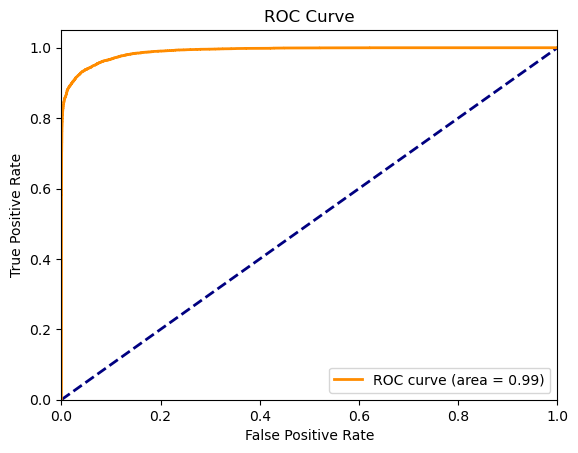

In [48]:
### ROC Curve ###
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=2)
roc_auc = roc_auc_score(y_test, y_pred, labels=[1, 2])

plt.figure()
plt.plot([0, 2], [0, 2], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


MSE: 1.0312019898419755


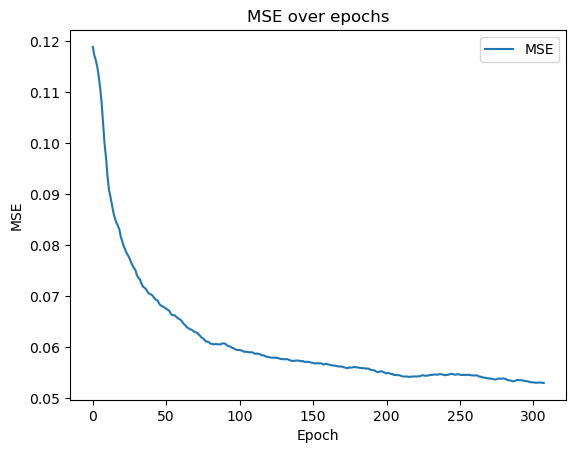

In [49]:
### MSE ###
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

# plot mse over epochs
plt.figure()
plt.plot(range(len(mse_over_epochs)), mse_over_epochs, label="MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE over epochs")
plt.legend()
plt.show()